# Moving Averages CINGULATE region

### 1) Imports

In [368]:
import os
import glob
import sys
import json

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [369]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

import torch

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn import metrics

import matplotlib.cm as cm

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig

In [370]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [371]:
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

### 2) Loading of subjects's distribution in the latent space
DataFrame is obtained during analysis of beta-VAE latent space (2 dimensions) for CINGULATE crops, according to the following steps:
- loading of trained model
- encoding of test controls and asymmetry benchmark subjects

In [372]:
if torch.cuda.is_available():
    device = "cuda:0"
print(device)

cuda:0


In [373]:
# def process_config(config) -> DictConfig:
#     """Does whatever operations on the config file
#     """

#     print(OmegaConf.to_yaml(config))
#     print("Working directory : {}".format(os.getcwd()))
#     config.input_size = eval(config.input_size)
#     print("config type: {}".format(type(config)))
#     return config

In [374]:
# from hydra.core.global_hydra import GlobalHydra
# model_dir = 'Runs/28_cingulate_back_to_2mm/Output/t-0.1/n-004_o-4'

# GlobalHydra.instance().clear()
# # Initialize hydra
# initialize(config_path=f"{model_dir}/.hydra")
# # compose from config.yaml, this composes a bunch of defaults in:
# config=compose(config_name="config.yaml")
# config = process_config(config)

In [375]:
# We load the mebeddings
result_dir = '/host/volatile/jc225751/Runs/28_cingulate_back_to_2mm/Output/t-0.1/n-004_o-4'
val_embeddings_file = f"{result_dir}/train_embeddings.pt"
embeddings = torch.load(val_embeddings_file)
print(embeddings.shape)

torch.Size([440, 4])


In [376]:
# We load the labels
with open(f"{result_dir}/train_filenames.json", 'r') as f:
    labels = json.load(f)
print(labels)

['953764', '825654', '707749', '137633', '185442', '650746', '102008', '201515', '164636', '167238', '436845', '159845', '150019', '146432', '571144', '814649', '209834', '871762', '152427', '116423', '573451', '151223', '580650', '123420', '103111', '618952', '177342', '325129', '124220', '214524', '152225', '173637', '199150', '209228', '185947', '122317', '101309', '134425', '878776', '644044', '316835', '111312', '517239', '118124', '761957', '615441', '103212', '217429', '825553', '102614', '211821', '141119', '880157', '204218', '134728', '424939', '378756', '122822', '173839', '165436', '108525', '187345', '131924', '248339', '114924', '510326', '144125', '270332', '561242', '170631', '421226', '200513', '826353', '154734', '146735', '116221', '141826', '129432', '233326', '121719', '136732', '221218', '169545', '107018', '930449', '164030', '137936', '227533', '138231', '702133', '157336', '163836', '206222', '529953', '162026', '748258', '675661', '552544', '150423', '779370',

In [377]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings)
cluster_labels = kmeans.labels_
clusters_centroids = kmeans.cluster_centers_
print(f"clusters centroids = {clusters_centroids.shape}")
print(f"Average silhouette score: {metrics.silhouette_score(embeddings, cluster_labels)}")


clusters centroids = (3, 4)
Average silhouette score: 0.42380642890930176


In [378]:
dstrb_sub = pd.DataFrame(embeddings.numpy(), index=labels, columns=[1, 2, 3, 4])
dstrb_sub['cluster_lab'] = cluster_labels

In [379]:
dstrb_sub.head()

,1,2,3,4,cluster_lab
953764,-1.359070,7.202079,14.599560,9.553591,0
825654,-1.086398,8.254256,12.667705,10.443875,0
707749,-1.006011,1.485899,-0.427999,5.192708,1
137633,-1.378512,6.381883,7.626342,9.415328,0
185442,-1.606740,0.368033,8.959540,1.375747,2


In [380]:
clusters_centroids = kmeans.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

cluster's centroids coordinates: 
 [[-1.32613869  6.67959144 11.35119072  9.19910054]
 [-1.13013508  4.13478214  2.70111448  5.86425765]
 [-1.26252312  2.63358357  7.78086795  2.58221394]]


In [381]:
central_1= closest_distance(clusters_centroids[0], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 1 is {central_1}")
central_2 = closest_distance(clusters_centroids[1], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 2 is {central_2}")

Closest subject to centroid of cluster 1 is 118932
Closest subject to centroid of cluster 2 is 173839


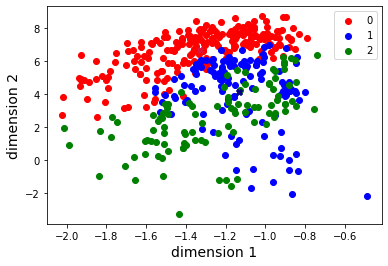

In [382]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[0:2]]) for i in range(len(dstrb_sub))])

color_dict = {0: 'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.cluster_lab]):
    ix = np.where(dstrb_sub.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
ax.scatter(clusters_centroids[0][0], clusters_centroids[0][1], color='crimson', marker='X')
ax.scatter(clusters_centroids[1][0], clusters_centroids[1][1], color='navy', marker='X')

plt.xlabel(f'dimension 1', fontsize=14)
plt.ylabel(f'dimension 2', fontsize=14)
plt.legend()
plt.show()

In [383]:
dstrb_sub.head()

,1,2,3,4,cluster_lab
953764,-1.359070,7.202079,14.599560,9.553591,0
825654,-1.086398,8.254256,12.667705,10.443875,0
707749,-1.006011,1.485899,-0.427999,5.192708,1
137633,-1.378512,6.381883,7.626342,9.415328,0
185442,-1.606740,0.368033,8.959540,1.375747,2


In [384]:
dstrb_sub.index[0]

'953764'

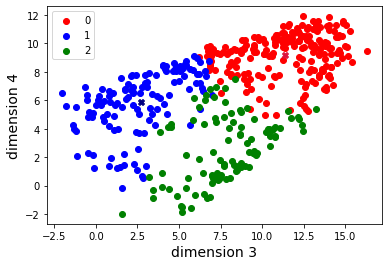

In [385]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[2:4]]) for i in range(len(dstrb_sub))])

color_dict = {0: 'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.cluster_lab]):
    ix = np.where(dstrb_sub.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = g)
    
ax.scatter(clusters_centroids[0][2], clusters_centroids[0][3], color='crimson', marker='X')
ax.scatter(clusters_centroids[1][2], clusters_centroids[1][3], color='navy', marker='X')
# ax.scatter(dstrb_sub[3]['113316'], dstrb_sub[4]['113316'], color='orange')
# ax.scatter(dstrb_sub[3]['144125'], dstrb_sub[4]['144125'], color='forestgreen')
# ax.scatter(dstrb_sub[3]['217126'], dstrb_sub[4]['217126'], color='black')

plt.xlabel(f'dimension 3', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.legend()
plt.show()

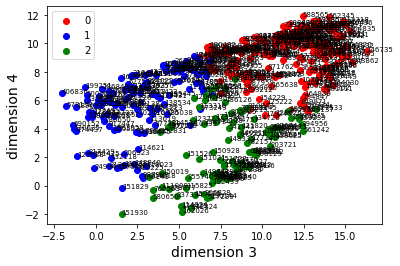

In [386]:
fig, ax = plt.subplots()
for g in np.unique([dstrb_sub.cluster_lab]):
    ix = np.where(dstrb_sub.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = g)
    for k, i in zip(range(len(ix[0])), ix[0]):
        ax.annotate(dstrb_sub.index[i], (x[k], y[k]),fontsize=7)
    
ax.scatter(clusters_centroids[0][2], clusters_centroids[0][3], color='crimson', marker='X')
ax.scatter(clusters_centroids[1][2], clusters_centroids[1][3], color='navy', marker='X')
# ax.scatter(dstrb_sub[3]['113316'], dstrb_sub[4]['113316'], color='orange')
# ax.scatter(dstrb_sub[3]['144125'], dstrb_sub[4]['144125'], color='forestgreen')
# ax.scatter(dstrb_sub[3]['217126'], dstrb_sub[4]['217126'], color='black')

plt.xlabel(f'dimension 3', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.legend()
plt.show()

In [387]:
cluster1 = dstrb_sub[dstrb_sub.cluster_lab==0]
cluster2 = dstrb_sub[dstrb_sub.cluster_lab==1]
assert(len(np.unique(list(cluster1.cluster_lab)))==1)
assert(len(np.unique(list(cluster2.cluster_lab)))==1)

### Creation of buckets dictionnary

In [388]:
bucket_path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rbuckets/'
suffix_path = '_normalized.bck'
buckets = {}
for sub in tqdm(list(labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    bucket = dtx.convert.bucket_aims_to_ndarray(bucket[0])
    buckets[sub] = bucket

100%|██████████| 440/440 [00:25<00:00, 17.17it/s]


In [389]:
subjects_c1 = cluster1.index
subjects_c2 = cluster2.index

buckets_c1 = {k: v for k,v in buckets.items() if k in list(subjects_c1)}
buckets_c2 = {k: v for k,v in buckets.items() if k in list(subjects_c2)}

In [390]:
cld.draw(list(buckets_c1.values())[0])

#### Alignement of the subjects to respective central subject

In [391]:
aligned_buckets_C1, aligned_rot_C1, aligned_transl_C1 = ma.align_buckets_by_ICP_batch(buckets_c1, central_1)
aligned_buckets_C2, aligned_rot_C2, aligned_transl_C2 = ma.align_buckets_by_ICP_batch(buckets_c2, central_2)

>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 118932: 100%|██████████| 211/211 [00:02<00:00, 100.31it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 173839: 100%|██████████| 126/126 [00:01<00:00, 96.93it/s] 


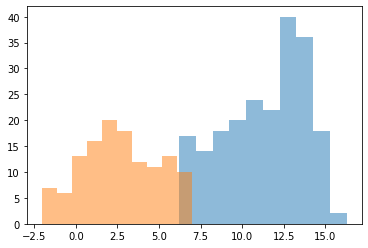

In [392]:
plt.hist(cluster1[3], alpha=0.5)
plt.hist(cluster2[3], alpha=0.5)
plt.show()

In [393]:
def subj_count_extreme_coords(isodf, axis, min_coord, max_coord, num_coord=10):
    coord_values = np.linspace(min_coord, max_coord, num_coord)
    step = (coord_values[1] - coord_values[0])
    midpoint_min = coord_values[0] + step/2
    midpoint_max = coord_values[num_coord-1] - step/2
    coord_under = [elt for elt in isodf[axis] if elt<midpoint_min]
    coord_over = [elt for elt in isodf[axis] if elt>midpoint_max]
    num_subj_under = len(coord_under)
    num_subj_over = len(coord_over)
    return num_subj_under, num_subj_over

def get_MA_coords(isodf, axis, num_subj_threshold, num_coord=10):
    min_subj_coord = min(isodf[axis])
    max_subj_coord = max(isodf[axis])
    step = (max_subj_coord - min_subj_coord)/num_coord
    num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    while ((num_subj_under<num_subj_threshold)|(num_subj_over<num_subj_threshold)):
        step = (max_subj_coord - min_subj_coord)/num_coord
        if num_subj_under<num_subj_threshold:
            min_subj_coord = min_subj_coord + step
        if num_subj_over<num_subj_threshold:
            max_subj_coord = max_subj_coord - step
        num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    return np.linspace(min_subj_coord, max_subj_coord, num_coord)

In [429]:
MA_coords = get_MA_coords(cluster1, 3, num_subj_threshold=14, num_coord=2)
step = step = MA_coords[1]-MA_coords[0]

In [430]:
MA_coords

array([11.23771787, 11.23771787])

In [396]:
step

1.6764287153879796

In [397]:
cluster1.index 

Index(['953764', '825654', '137633', '102008', '164636', '571144', '814649',
       '209834', '871762', '573451',
       ...
       '558960', '140117', '942658', '201111', '154835', '562345', '715950',
       '792867', '183741', '118932'],
      dtype='object', length=211)

In [398]:
SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(MA_coords, aligned_buckets_C1, cluster1, axis_n=3, FWHM=0.5)
SPAM_vols_c1, shift1 = ma.moving_averages_tools.calc_one_MA_volume(aligned_buckets_C1, cluster1, axis_n=3, FWHM=0.5)

Calculating moving averages: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


In [432]:
SPAM_vols_c1.items()

dict_items([(9.561289151509603, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],


In [399]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume,
                    gblur_sigma=0.0,
                    threshold=0.45,
                    deciReductionRate=0,
                    smoothRate=0.25)
    #SPAM_meshes[k] = dtx.mesh.shift_aims_mesh(SPAM_meshes[k], 2*shift1[k])
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=30)

100%|██████████| 3/3 [00:00<00:00, 23.17it/s]


In [400]:
fig = cld.draw(list(SPAM_vols_c1.values())[0], th_min=0.2)
cld.draw(list(SPAM_meshes.values())[0], fig=fig)

In [401]:
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_{x}_2cluster33.mesh")#### Saving of average crops

100%|██████████| 3/3 [00:00<00:00, 106.71it/s]


### Whole cluster analysis

In [402]:
clusters_centroids

array([[-1.32613869,  6.67959144, 11.35119072,  9.19910054],
       [-1.13013508,  4.13478214,  2.70111448,  5.86425765],
       [-1.26252312,  2.63358357,  7.78086795,  2.58221394]])

In [403]:
np.mean(clusters_centroids,axis=0)

array([-1.23959896,  4.48265238,  7.27772439,  5.88185738])

In [404]:
clusters_centroids = kmeans.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")
centroid = np.mean(clusters_centroids, axis=0)
print(centroid)

central = closest_distance(centroid, dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster is {central}")
print(dstrb_sub[3][str(central)], dstrb_sub[4][str(central)])

cluster's centroids coordinates: 
 [[-1.32613869  6.67959144 11.35119072  9.19910054]
 [-1.13013508  4.13478214  2.70111448  5.86425765]
 [-1.26252312  2.63358357  7.78086795  2.58221394]]
[-1.23959896  4.48265238  7.27772439  5.88185738]
Closest subject to centroid of cluster is 141826
7.0088634 6.3954144


In [405]:
aligned_buckets, aligned_rot, aligned_transl = ma.align_buckets_by_ICP_batch(buckets, central)

>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 141826: 100%|██████████| 440/440 [00:03<00:00, 122.36it/s]


In [406]:
MA_coords = get_MA_coords(dstrb_sub, 3, num_subj_threshold=14, num_coord=5)
step = step = MA_coords[1]-MA_coords[0]

In [407]:
MA_coords

array([ 1.63305283,  4.37691867,  7.12078452,  9.86465037, 12.60851622])

In [408]:
step

2.7438658475875854

In [409]:
len(dstrb_sub)

440

In [410]:
#SPAM_centers_c1 = [-2.05716]
#SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(SPAM_centers_c1, aligned_buckets_C1, cluster1, axis_n=1, FWHM=1)
SPAM_vols, shift = ma.calc_MA_volumes_batch(MA_coords, aligned_buckets, dstrb_sub, axis_n=1, FWHM=1)

Calculating moving averages: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


In [411]:
# Draws first volume in the brochette
cld.draw(list(SPAM_vols.values())[0], th_min=0.3)

In [412]:
# Draws last volume in the brochette
cld.draw(list(SPAM_vols.values())[-1], th_min=0.3)

In [413]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume,
                    gblur_sigma=0,
                    threshold=0.45,
                    deciReductionRate=0,
                    smoothRate=0.4)
    #SPAM_meshes[k] = dtx.mesh.shift_aims_mesh(SPAM_meshes[k], 2*shift1[k])
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=20)

100%|██████████| 5/5 [00:00<00:00, 27.68it/s]


In [414]:
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_{x}_2cluster44.mesh")#### Saving of average crops

100%|██████████| 5/5 [00:00<00:00, 647.73it/s]


In [415]:
cld.draw(list(SPAM_meshes.values())[0])

In [416]:
cld.draw(list(SPAM_meshes.values())[4])

In [417]:
fig = cld.draw(list(SPAM_vols.values())[0], th_min=0.2)
cld.draw(list(SPAM_meshes.values())[0], fig=fig)

In [418]:
SPAM_centers_c2 = [0]
SPAM_vols_c2, shift2 = ma.calc_MA_volumes_batch(SPAM_centers_c2, aligned_buckets_C2, cluster2, axis_n=3, FWHM=1)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


#### Visualization of average crops of both clusters

In [419]:
fig = cld.draw(shifted_SPAM_meshes)
ma.plot.brochette_layout(fig, "subjects meshes")

In [420]:

for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_{x}_2cluster2.mesh")

100%|██████████| 5/5 [00:00<00:00, 357.35it/s]


# Saves extreme bucket files

In [421]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[2:4]]) for i in range(len(dstrb_sub))])

# Selects subjects whose 3rd dimension is higher than 14
ix_sup14 = np.where(arr[:,0] > 14.)
print(ix_sup14)

(array([  0,  14,  41,  50,  74,  85, 109, 123, 131, 135, 145, 163, 182,
       189, 225, 244, 270, 280, 285, 287, 288, 299, 303, 325, 327, 359,
       367, 413, 428]),)


In [422]:
for ix in np.nditer(ix_sup14):
    sub = dstrb_sub.index[ix]
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(buckets[sub]), f">14_{sub}.bck")

In [423]:
# Selects subjects whose 3rd dimension is less than 1
ix_inf1 = np.where(arr[:,0] < 1.)
print(ix_inf1)

(array([  2,   7,  33,  40,  47, 107, 120, 142, 159, 162, 181, 199, 209,
       217, 253, 254, 258, 263, 294, 295, 306, 313, 315, 335, 340, 354,
       372, 375, 386, 404, 419, 433]),)


In [424]:
for ix in np.nditer(ix_inf1):
    sub = dstrb_sub.index[ix]
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(buckets[sub]), f"<1_{sub}.bck")